# The Future is Now: Patterns in Global Temperature Trends Across the World

Continued from `Analysis 3 Cluster Hierarchical.ipynb`.

## Dependency Installation & Imports

In [1]:
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow pycountry_convert kgcpy scipy fastdtw statsmodels networkx pyvis

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
global_correlation = 0.895059831369191

## Further Pattern Examination

### Data Preparation (Standardization)

In [21]:
with open('Data_augmented.csv', 'r', encoding='utf-8') as file:
    df = pd.read_csv(file, encoding='utf-8')

df = df.drop(['Latitude', 'Longitude', 'AbsLatitude', 'AbsLongitude'], axis=1)

df.head()

,City,Year,AverageTemperature,Country,NumericLatitude,NumericLongitude,Continent,kcc
0,A Coruña,1880,12.837750,Spain,42.59,-8.73,Europe,Csb
1,A Coruña,1881,13.405000,Spain,42.59,-8.73,Europe,Csb
2,A Coruña,1882,12.776250,Spain,42.59,-8.73,Europe,Csb
3,A Coruña,1883,12.260833,Spain,42.59,-8.73,Europe,Csb
4,A Coruña,1884,12.693250,Spain,42.59,-8.73,Europe,Csb


### Model-Based Clustering with Gaussian Mixture Models (GMMs)

In [22]:
city_correlations_dict = {}

for city, group in df.groupby('City'):
    correlation = group['AverageTemperature'].corr(group['Year'])
    city_correlations_dict[city] = correlation

city_correlations_df = pd.DataFrame(list(city_correlations_dict.items()), columns=['City', 'corr'])
df = pd.merge(df, city_correlations_df, on='City', how='left')

In [23]:
scaler = MinMaxScaler()
df[['ScaledLatitude', 'ScaledLongitude']] = scaler.fit_transform(df[['NumericLatitude', 'NumericLongitude']])

In [24]:
df_updated = df.groupby('City')['AverageTemperature'].mean().reset_index(name='MeanAverageTemperature')

In [25]:
unique_cities = df[['City', 'ScaledLatitude', 'ScaledLongitude']].drop_duplicates('City')
df_updated = pd.merge(df_updated, unique_cities, on='City')

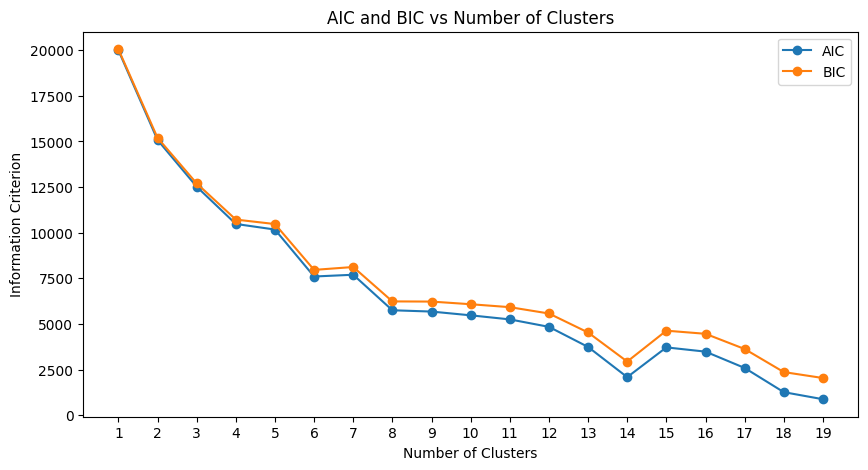

In [26]:
X = df_updated[['MeanAverageTemperature', 'ScaledLatitude', 'ScaledLongitude']]

n_components_range = range(1, 20)
aics = []
bics = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)

    aics.append(gmm.aic(X))
    bics.append(gmm.bic(X))


plt.figure(figsize=(10, 5))
plt.plot(n_components_range, aics, label='AIC', marker='o')
plt.plot(n_components_range, bics, label='BIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('AIC and BIC vs Number of Clusters')
plt.xticks(n_components_range)
plt.show()

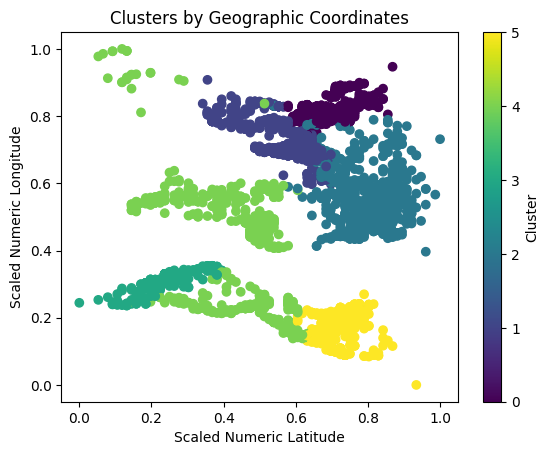

In [27]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

X = df_updated[['MeanAverageTemperature', 'ScaledLatitude', 'ScaledLongitude']]

n_components = 6

# Initialize and fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X)

cluster_labels = gmm.predict(X)

df_updated['Cluster'] = cluster_labels

plt.scatter(df_updated['ScaledLatitude'], df_updated['ScaledLongitude'], c=df_updated['Cluster'], cmap='viridis')
plt.xlabel('Scaled Numeric Latitude')
plt.ylabel('Scaled Numeric Longitude')
plt.title('Clusters by Geographic Coordinates')
plt.colorbar(label='Cluster')
plt.show()

In [28]:
df_unique_cities = df.drop_duplicates(subset='City')[['City', 'Country', 'Continent', 'kcc', 'corr', 'NumericLatitude', 'NumericLongitude']]
df_updated = pd.merge(df_updated, df_unique_cities, on='City', how='left')

In [29]:
df_gmm = df_updated
df_gmm = df_gmm[['Country', 'NumericLatitude', 'NumericLongitude', 'Continent', 'kcc', 'City', 'Cluster']]
df_gmm = df_gmm.sort_values(by=['Cluster', 'City']).reset_index(drop=True)
outfile = 'Data_gmm.csv'

df_gmm.to_csv(f'{outfile}', index=False)

print(f'Exported gmm-clustered cities to {outfile}')

Exported dbscan cities to Data_gmm.csv


In [30]:
df_merged = pd.merge(df, df_updated[['City', 'Cluster']], on='City', how='left')

#### Cluster Visualizations

1. Unique Cities in each cluster
2. Unique Countries in each cluster
3. Proportion of Continents in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
4. Proportion of climates in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
5. For each cluster:
   1. Averaged AverageTemperature by Year & correlations
   2. AverageTemperature by Year & correlations
   3. Box & Whiskers plots to look at geographic spread (Latitude, Longitude)

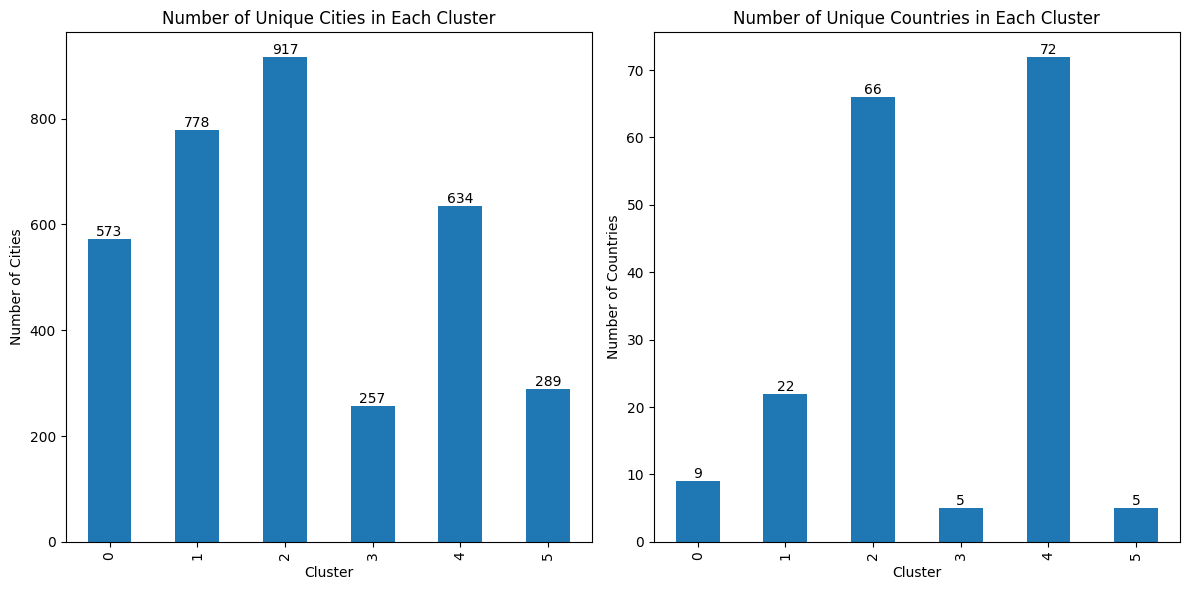

In [31]:
# Plotting the number of unique cities and countries in each cluster
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cities_per_cluster = df_merged.groupby('Cluster')['City'].nunique()
cities_per_cluster.plot(kind='bar')
plt.title('Number of Unique Cities in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Cities')
for index, value in enumerate(cities_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.subplot(1, 2, 2)
countries_per_cluster = df_merged.groupby('Cluster')['Country'].nunique()
countries_per_cluster.plot(kind='bar')
plt.title('Number of Unique Countries in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Countries')
for index, value in enumerate(countries_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Visualization & correlation of averaged clusters

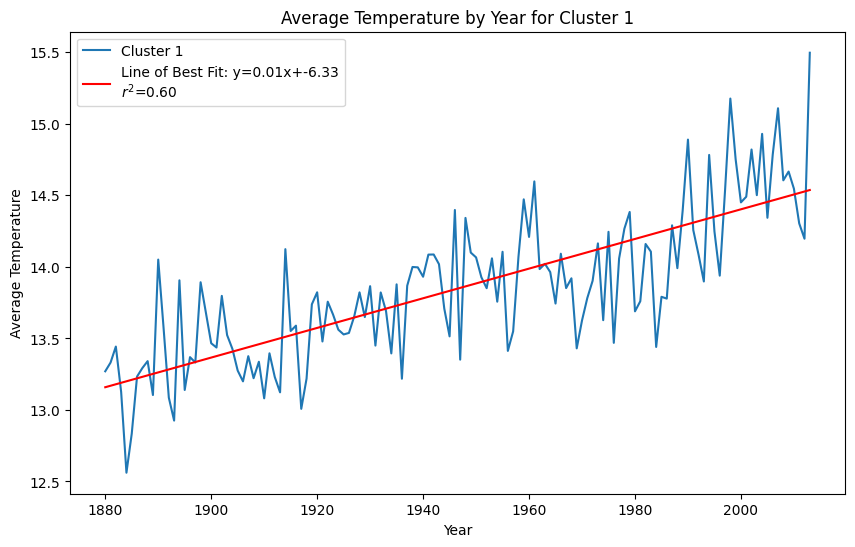

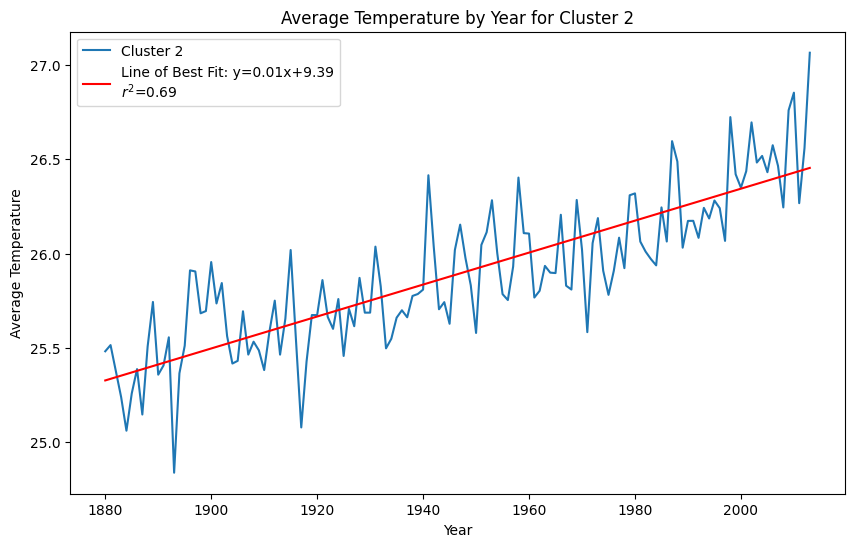

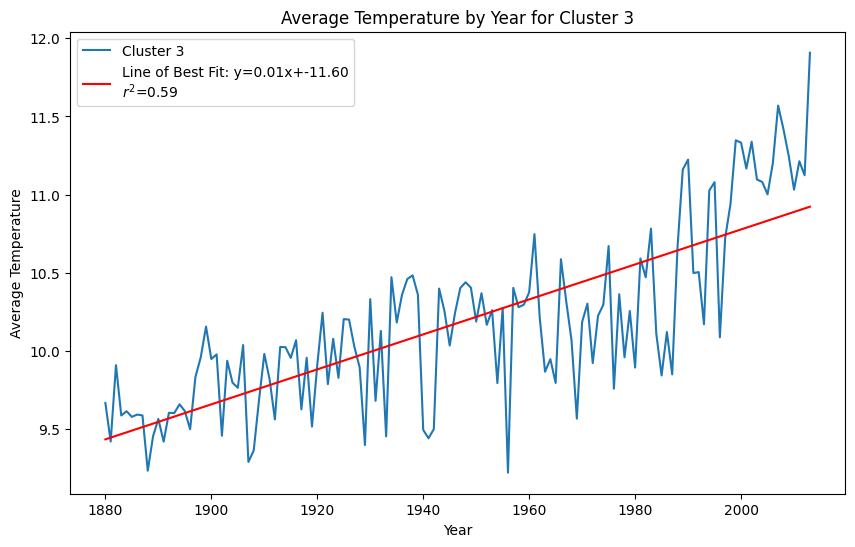

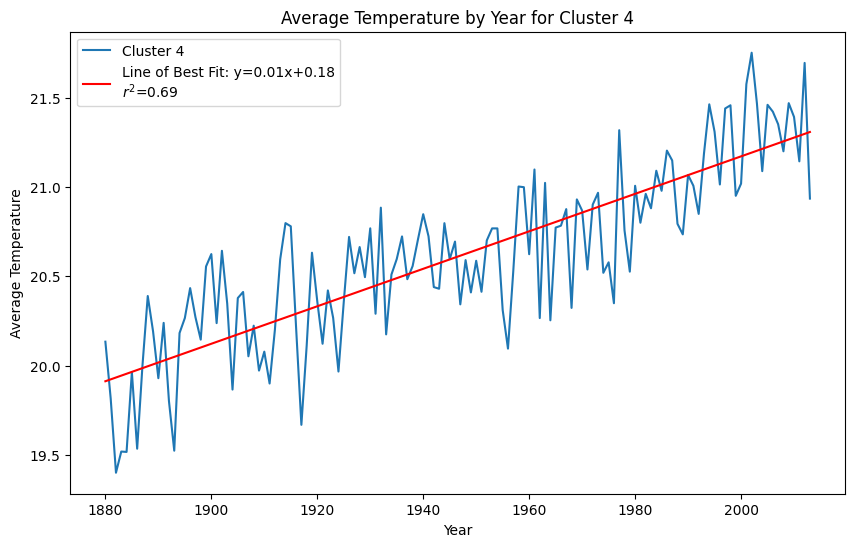

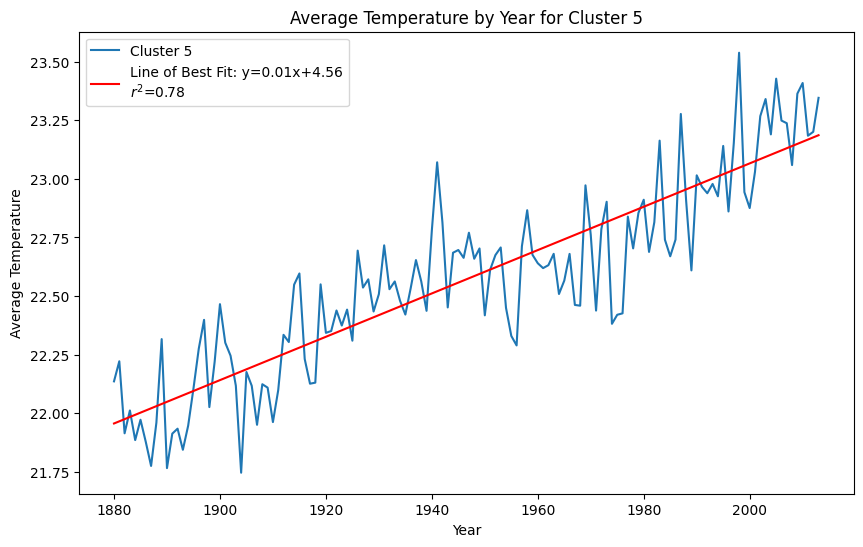

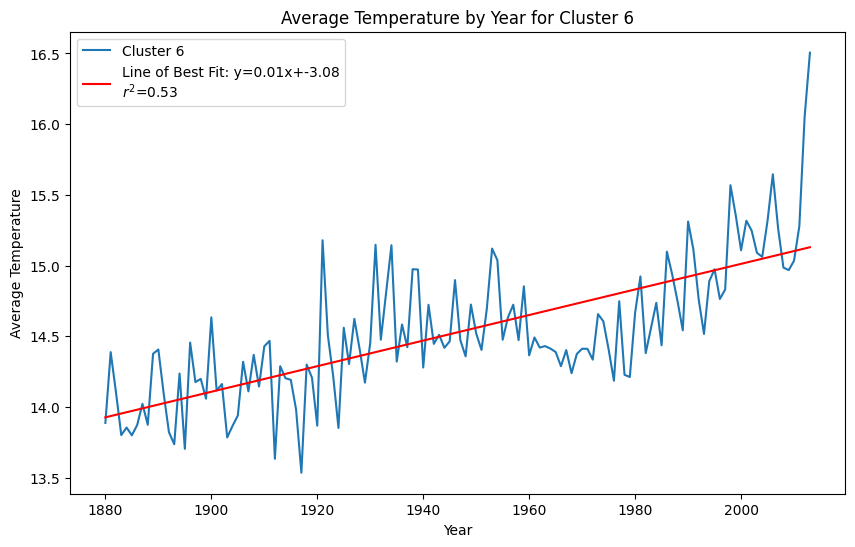

In [35]:
n_clusters = np.sort(df_merged['Cluster'].unique())

for cluster in n_clusters:
    cluster_data = df_merged[df_merged['Cluster'] == cluster]
    year_temperature = cluster_data.groupby('Year')['AverageTemperature'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.plot(year_temperature['Year'], year_temperature['AverageTemperature'], label=f'Cluster {cluster+1}')
    
    # Line of best fit
    slope, intercept, r_value, _, _ = linregress(year_temperature['Year'], year_temperature['AverageTemperature'])
    line = slope * year_temperature['Year'] + intercept
    plt.plot(year_temperature['Year'], line, 'r', label=f'Line of Best Fit: y={slope:.2f}x+{intercept:.2f}\n$r^2$={r_value**2:.2f}')
    
    plt.title(f'Average Temperature by Year for Cluster {cluster+1}')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature')
    plt.legend()
    plt.show()

Relative abundance of continents

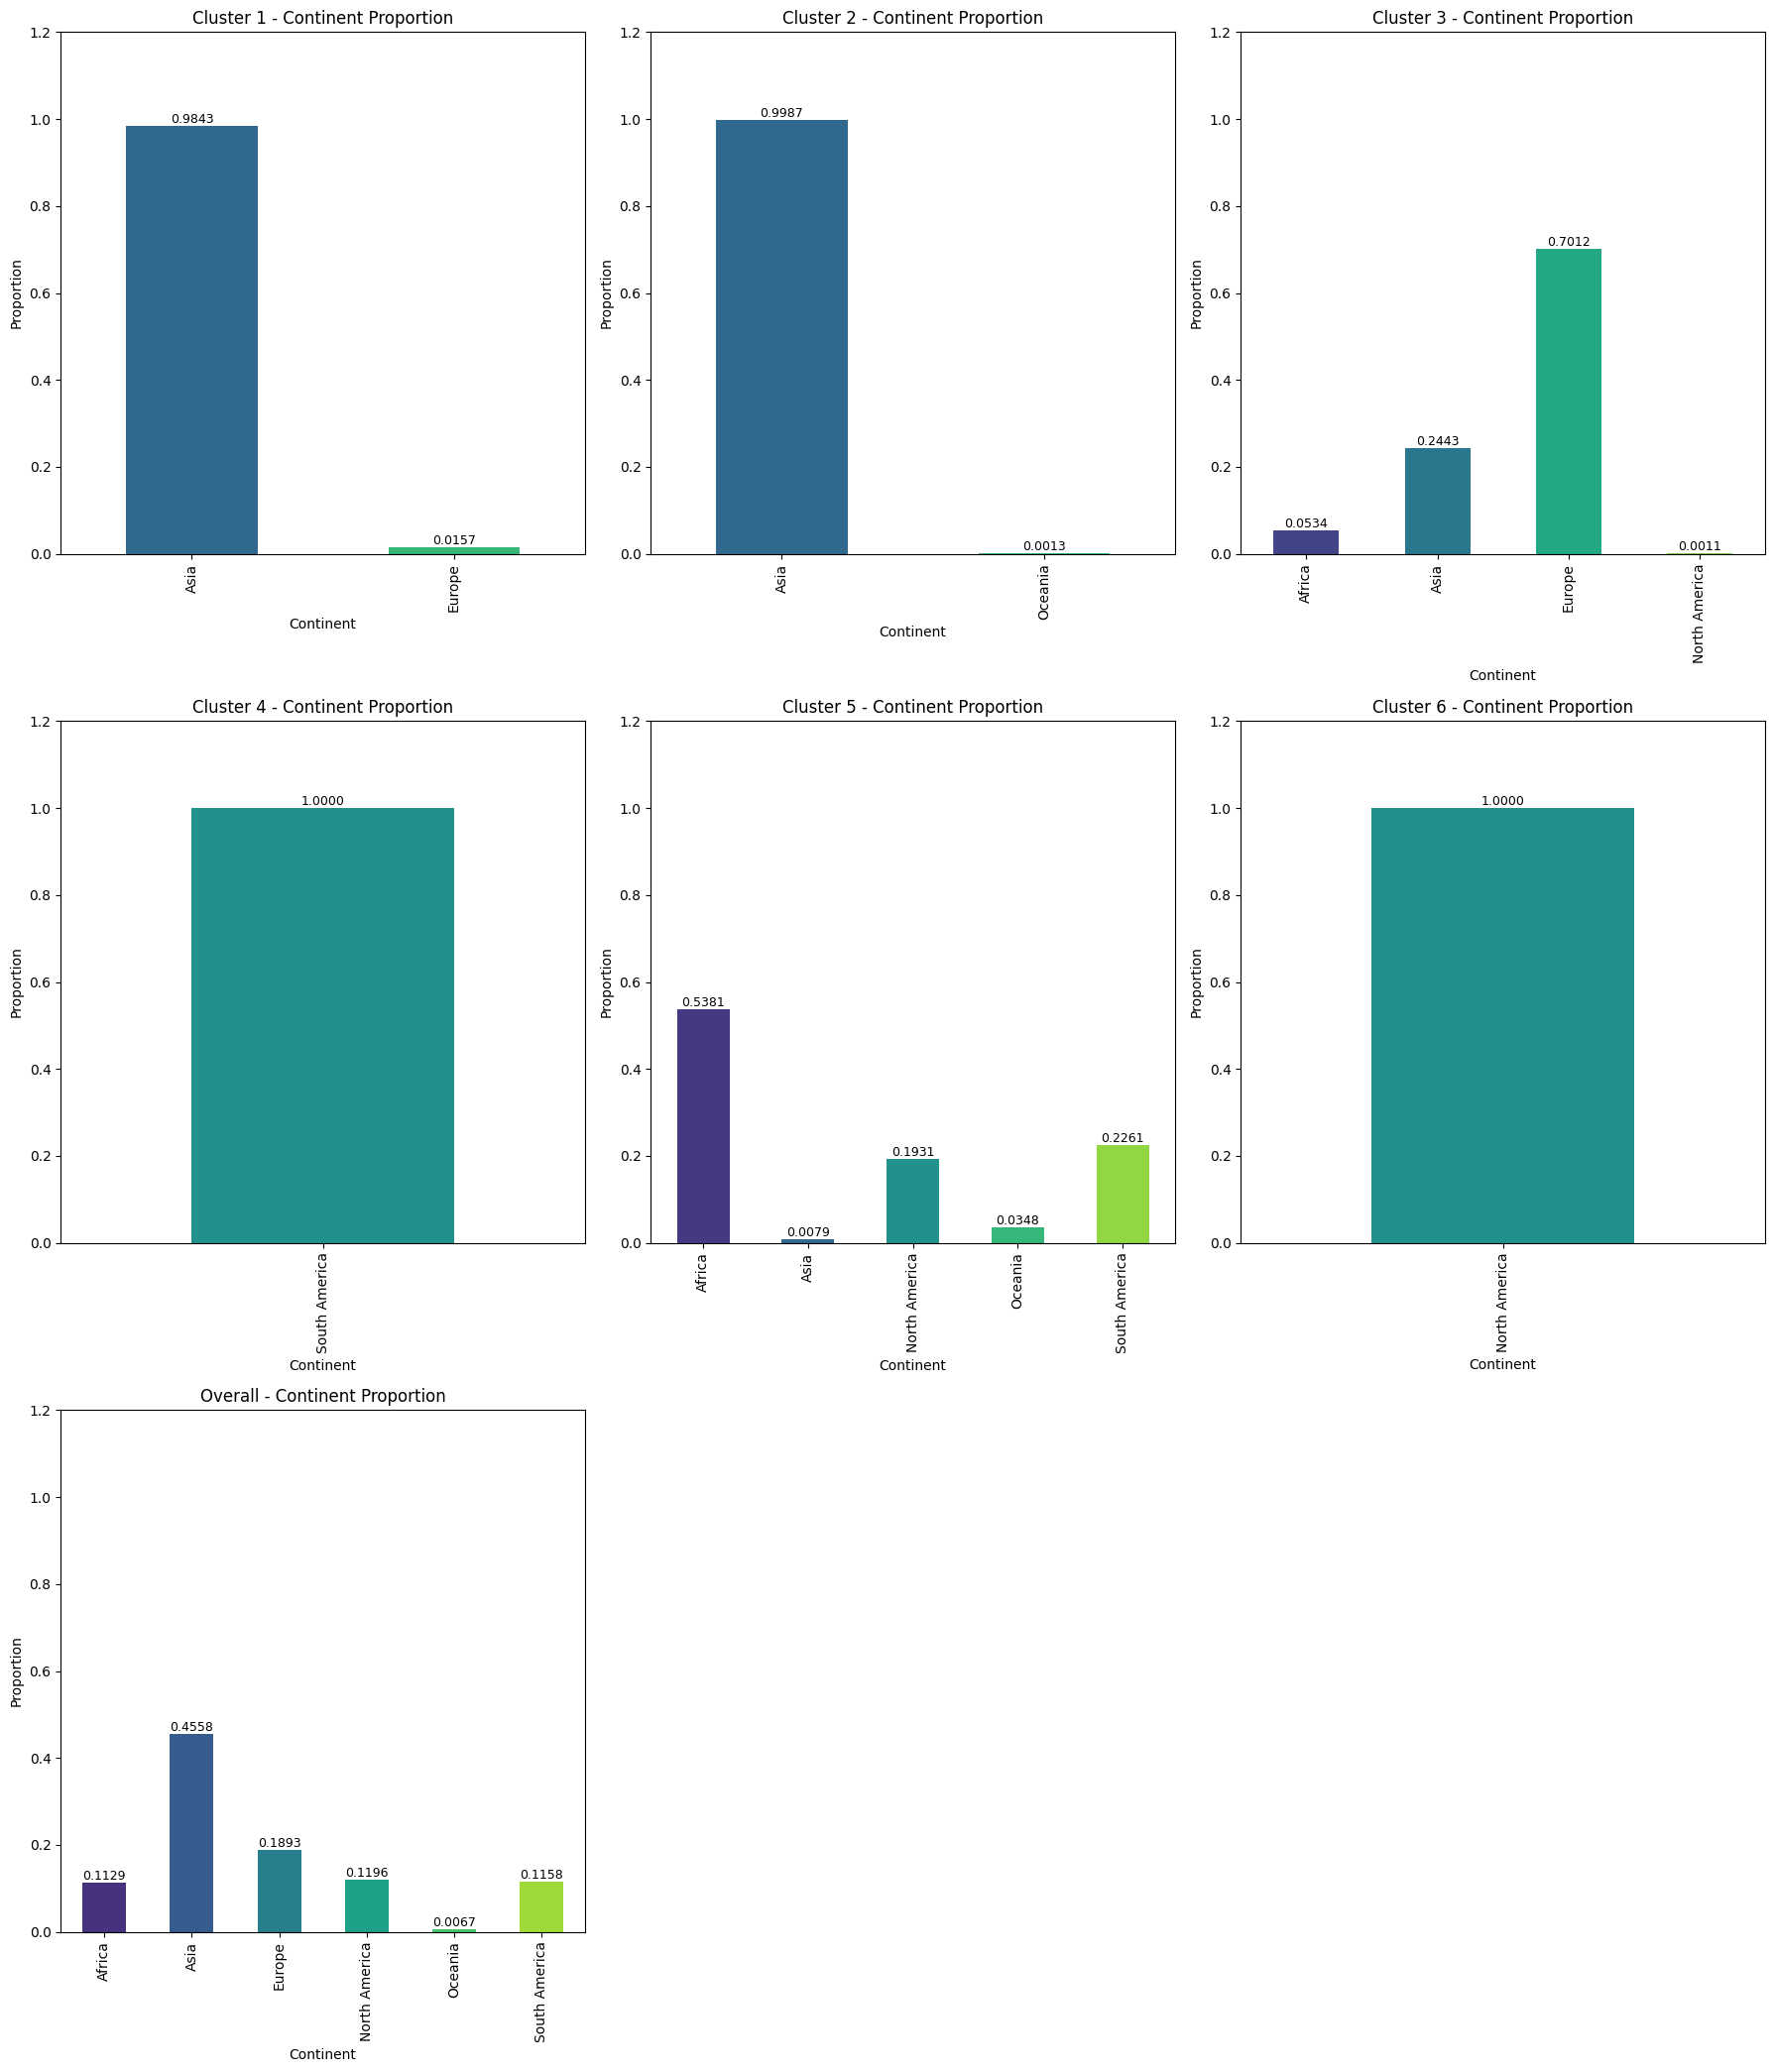

In [37]:
def add_labels(ax, values):
    for index, value in enumerate(values):
        ax.text(index, value, f"{value:.4f}", ha='center', va='bottom', fontsize=9, color='black')

n_clusters = len(np.sort(df_merged['Cluster'].unique()))

# Calculate grid size for subplots
n_rows = int(np.ceil(n_clusters / 3)) + 1
fig, axs = plt.subplots(n_rows, 3, figsize=(18, n_rows * 7))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

# Cluster continent abundance
for i, cluster in enumerate(np.sort(df_merged['Cluster'].unique())):
    ax = axs.flat[i]
    cluster_continent_abundance = df_merged[df_merged['Cluster'] == cluster]['Continent'].value_counts(normalize=True).sort_index()
    
    cluster_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_continent_abundance)))
    cluster_label = 'Noise' if cluster == -1 else f'Cluster {cluster+1}'
    ax.set_title(f'{cluster_label} - Continent Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1.2)
    add_labels(ax, cluster_continent_abundance.values)

# overall continent abundance
ax = axs.flat[n_clusters]
overall_continent_abundance = df['Continent'].value_counts(normalize=True).sort_index()
overall_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_continent_abundance)))
ax.set_title('Overall - Continent Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1.2)
add_labels(ax, overall_continent_abundance.values)

# Hide any unused subplots
for i in range(n_clusters + 1, n_rows * 3):
    if i < len(axs.flat):
        fig.delaxes(axs.flat[i])

plt.tight_layout()
plt.show()

Relative abundance of Koppen climate classifications

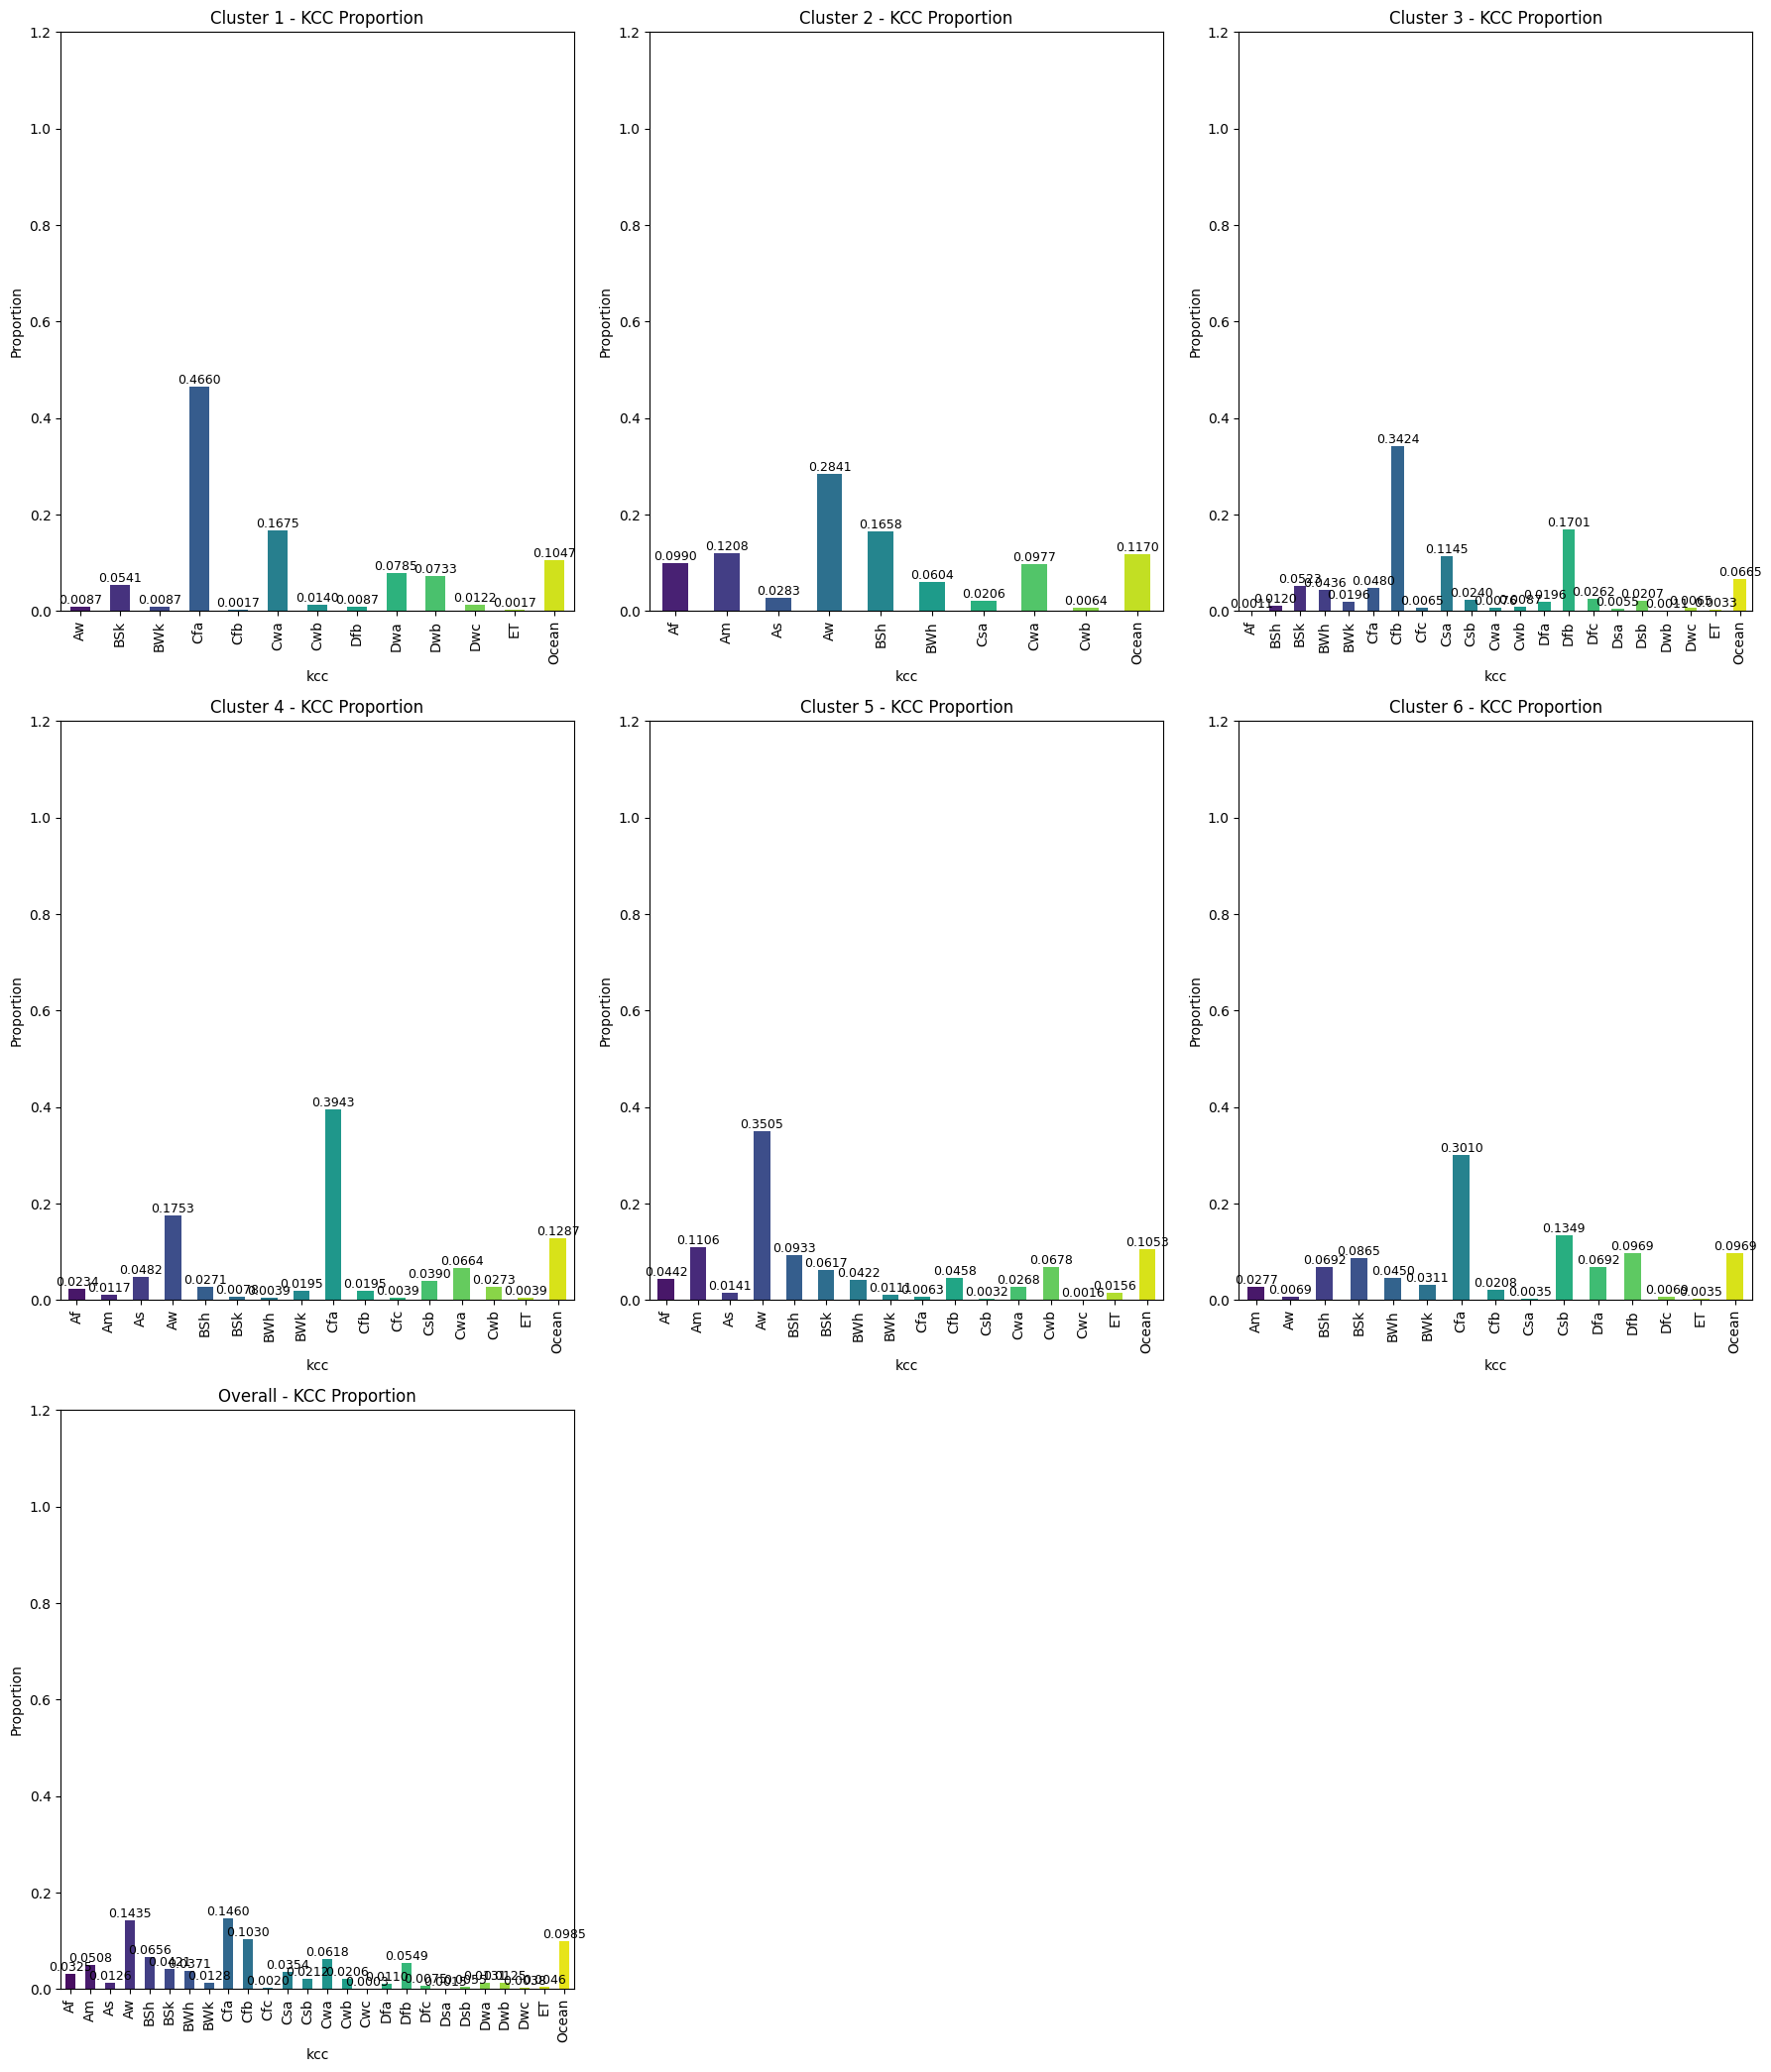

In [38]:
n_rows = int(np.ceil(n_clusters / 3)) + 1 
fig, axs = plt.subplots(n_rows, 3, figsize=(18, n_rows * 7))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

# Cluster KCC abundance
for i, cluster in enumerate(np.sort(df_merged['Cluster'].unique())):
    ax = axs.flat[i]
    cluster_kcc_abundance = df_merged[df_merged['Cluster'] == cluster]['kcc'].value_counts(normalize=True).sort_index()
    
    cluster_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_kcc_abundance)))
    cluster_label = 'Noise' if cluster == -1 else f'Cluster {cluster+1}'
    ax.set_title(f'{cluster_label} - KCC Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1.2)
    add_labels(ax, cluster_kcc_abundance.values)

# Overall KCC abundance
ax = axs.flat[n_clusters]
overall_kcc_abundance = df['kcc'].value_counts(normalize=True).sort_index()
overall_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_kcc_abundance)))
ax.set_title('Overall - KCC Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1.2)
add_labels(ax, overall_kcc_abundance.values)

for i in range(n_clusters + 1, n_rows * 3):
    if i < len(axs.flat):
        fig.delaxes(axs.flat[i])

plt.tight_layout()
plt.show()

Visualize as heatmaps

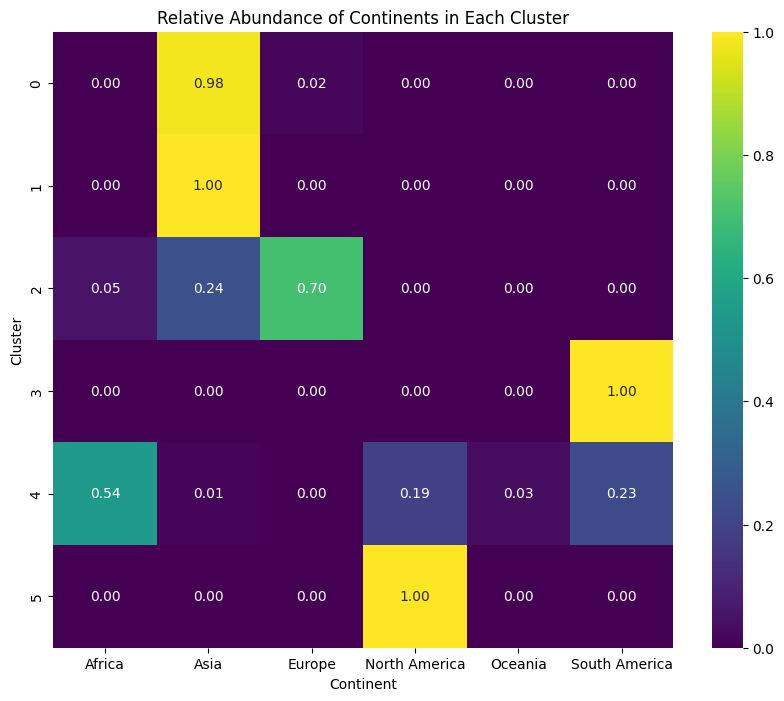

In [39]:
continent_cluster_proportion = pd.crosstab(df_merged['Cluster'], df_merged['Continent'], normalize='index')
plt.figure(figsize=(10, 8))
sns.heatmap(continent_cluster_proportion, annot=True, cmap='viridis', fmt=".2f")
plt.title('Relative Abundance of Continents in Each Cluster')
plt.xlabel('Continent')
plt.ylabel('Cluster')
plt.show()

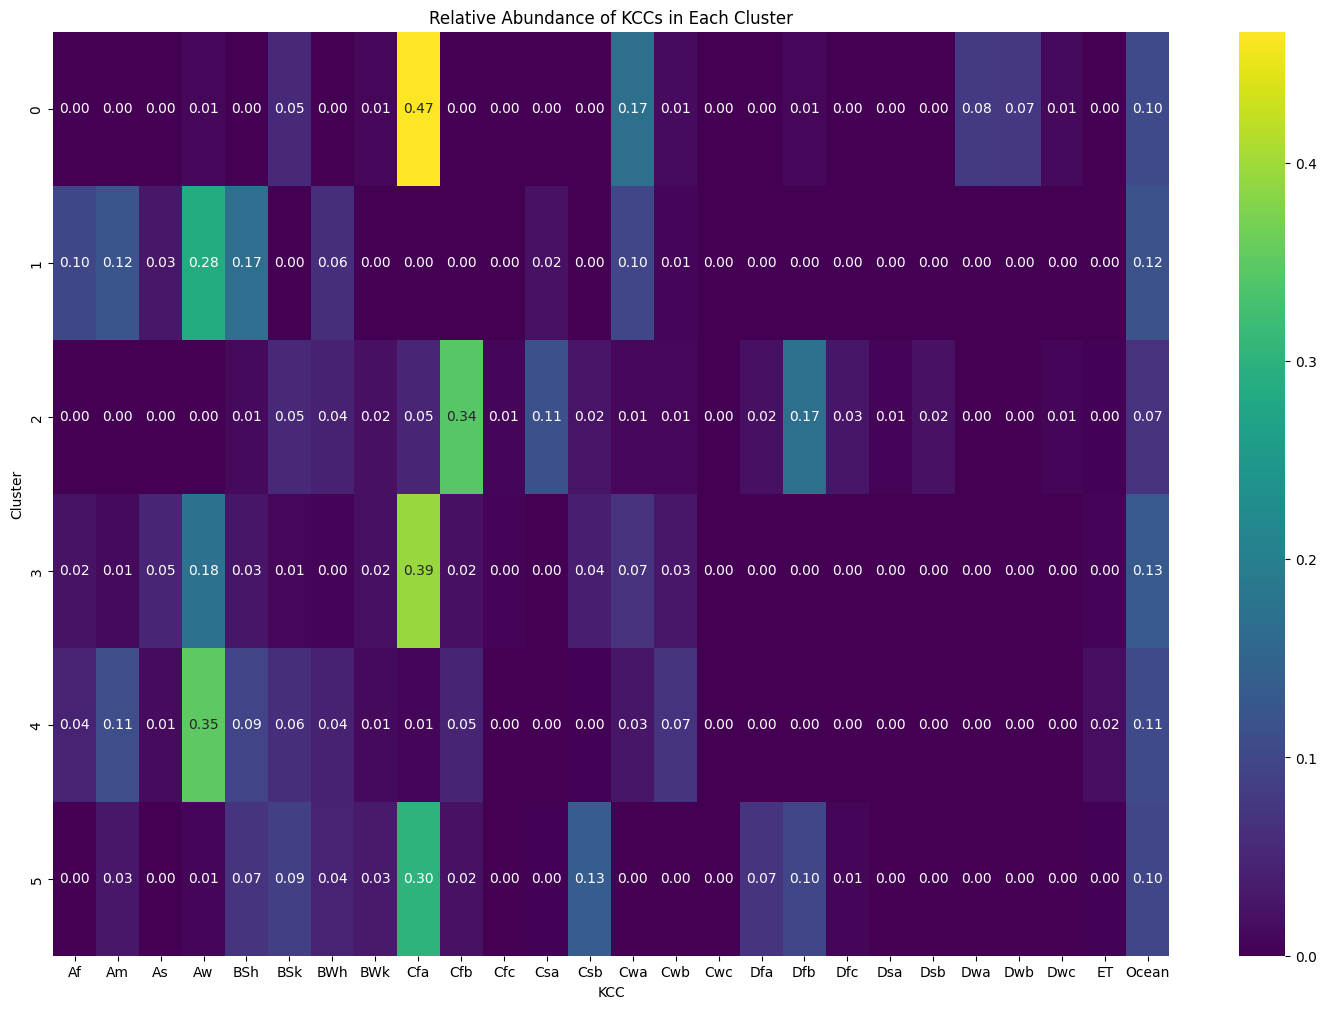

In [41]:
kcc_cluster_proportion = pd.crosstab(df_merged['Cluster'], df_merged['kcc'], normalize='index')
plt.figure(figsize=(18, 12))
sns.heatmap(kcc_cluster_proportion, annot=True, cmap='viridis', fmt=".2f")
plt.title('Relative Abundance of KCCs in Each Cluster')
plt.xlabel('KCC')
plt.ylabel('Cluster')
plt.show()

Visualization of geographic spread (Latitude, Longitude) for each cluster

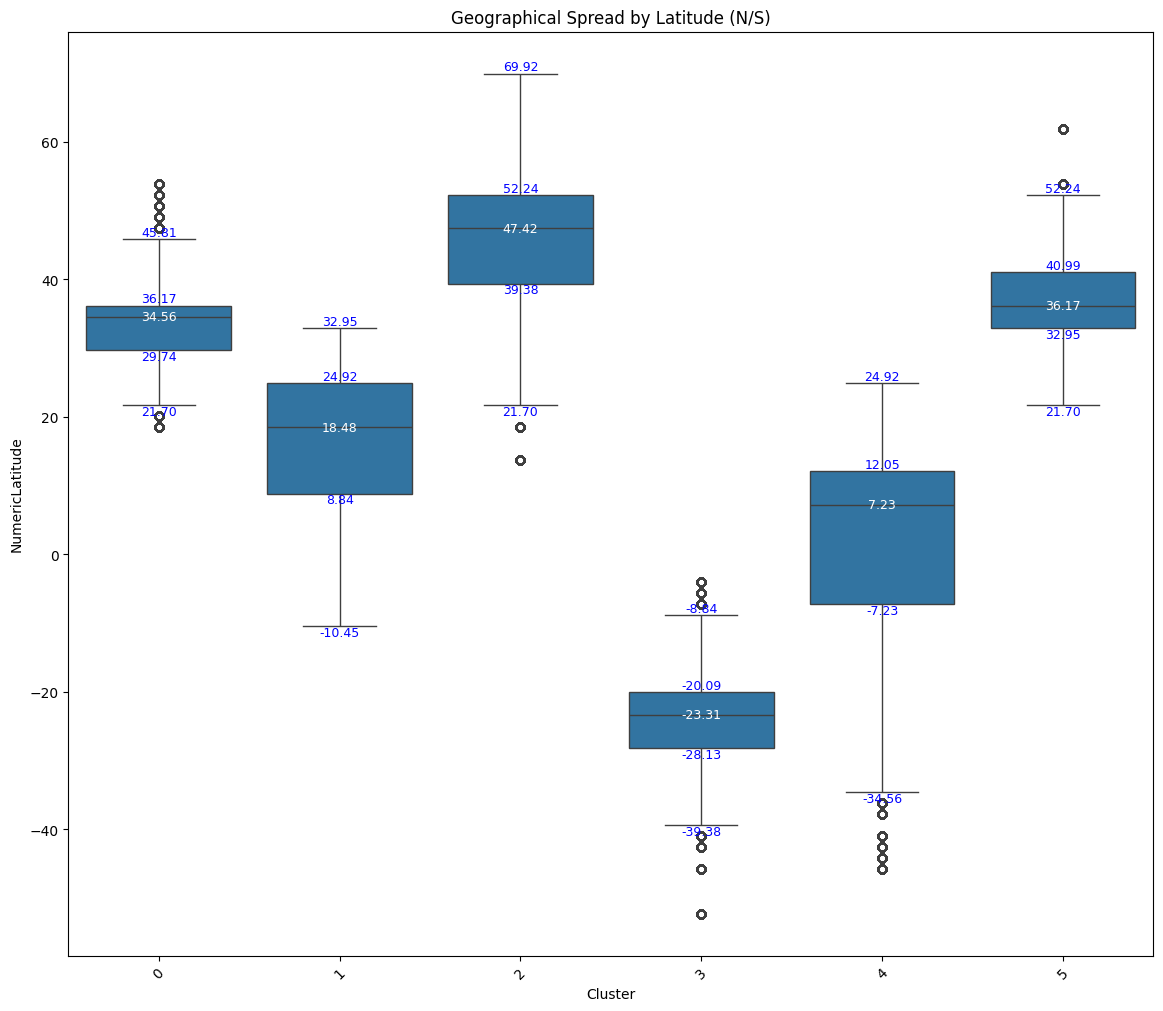

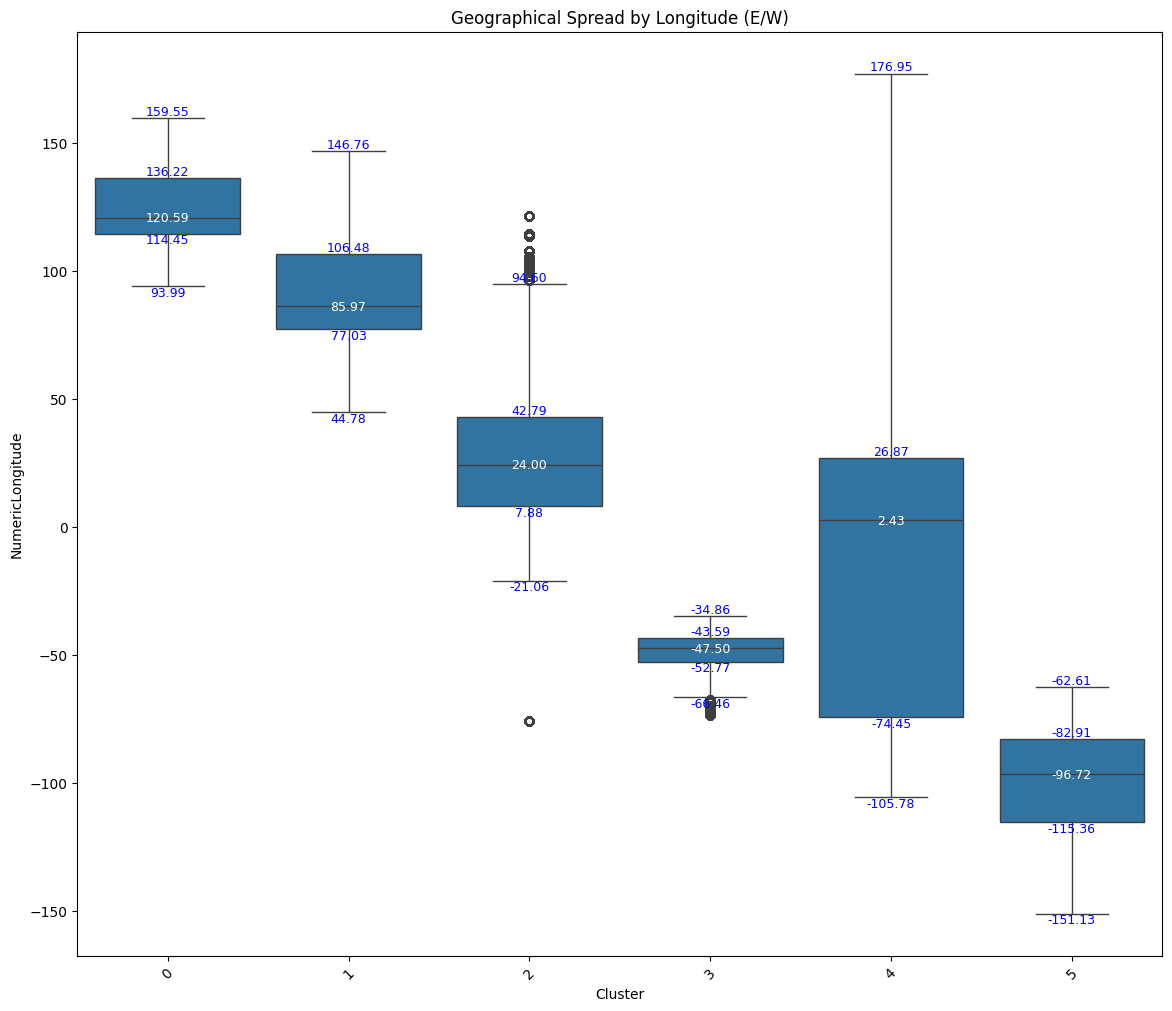

In [42]:
plt.figure(figsize=(14, 12))
sns.boxplot(x='Cluster', y='NumericLatitude', data=df_merged)

# Ensure you account for the noise cluster (-1) if present
unique_clusters = np.sort(df_merged['Cluster'].unique())
for cluster in unique_clusters:
    cluster_latitudes = df_merged[df_merged['Cluster'] == cluster]['NumericLatitude']
    percentiles = np.percentile(cluster_latitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_latitudes[cluster_latitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_latitudes[cluster_latitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    cluster_index = np.where(unique_clusters == cluster)[0][0]  # Find the index of the cluster for plotting
    plt.text(cluster_index, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(cluster_index, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(cluster_index, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Latitude (N/S)')
plt.ylabel('NumericLatitude')
plt.xlabel('Cluster')
plt.xticks(rotation=45)  # Ensure cluster labels are readable
plt.show()

plt.figure(figsize=(14, 12))
sns.boxplot(x='Cluster', y='NumericLongitude', data=df_merged)

for cluster in unique_clusters:
    cluster_longitudes = df_merged[df_merged['Cluster'] == cluster]['NumericLongitude']
    percentiles = np.percentile(cluster_longitudes, [25, 50, 75])
    lower_whisker = np.min(cluster_longitudes[cluster_longitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_longitudes[cluster_longitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    cluster_index = np.where(unique_clusters == cluster)[0][0]
    plt.text(cluster_index, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(cluster_index, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(cluster_index, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Longitude (E/W)')
plt.ylabel('NumericLongitude')
plt.xlabel('Cluster')
plt.xticks(rotation=45)
plt.show()